# TMS Analysis
Generating figures 3-5 and S1.

# Imports

Note to self: Modify ```~/.ipython/profile_default/startup/00-add-syspath.py``` to add local directories to jupyter path.

In [18]:
# !bash /root/eigenestimation/scripts/1_tms/train_tms_eigenmodel.sh

In [19]:
# Remember to login to wandb!
import torch
import matplotlib.pyplot as plt
import copy 
import pandas as pd
import seaborn as sns
# Atomic save saves the checkpoint in a weird module setup - this is a hack to get around that
import sys
sys.path.append("/root/eigenestimation/eigenestimation")

# Append module directory for imports
import numpy as np
from eigenestimation.toy_models.tms import AutoencoderSymmetric,  AutoencoderParallel  # Import your model
from eigenestimation.evaluation.networks import DrawNeuralNetwork
from eigenestimation.eigenmodel.eigenmodel import EigenModel
from eigenestimation.utils.loss import MSELoss
import notebooks.figure_names as figure_names

# Geneate sparse features
from eigenestimation.toy_models.data import GenerateTMSInputs
import matplotlib.cm as cm
import matplotlib.colors as np_colors

model_path = "../outputs/toy_models/tms.pt"
eigenmodel_path = "../outputs/eigenmodels/tms.pt"


In [20]:
eigenmodel_checkpoint = torch.load(eigenmodel_path)
eigenmodel = eigenmodel_checkpoint['model']
subnetworks = eigenmodel.construct_subnetworks()


# Figure S2: TMS embedding directions

3
5
4
2
1


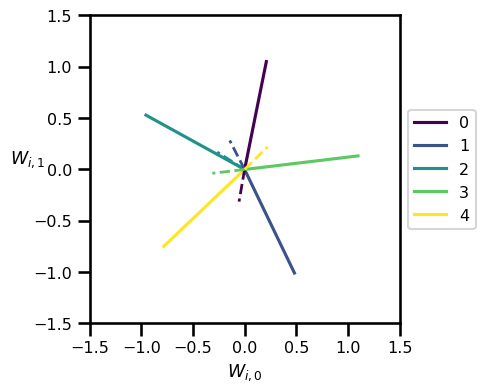

In [21]:
# Load TMS model
input_dim = 5
hidden_dim = 2
n_networks = 3

model = torch.load(model_path)['model']

# Plot TMS representations.
en = copy.deepcopy(model.W_in).detach().cpu().numpy().transpose()

plt.figure(figsize=(4,4))
# Iterate through different colors
colors = plt.cm.viridis(np.linspace(0, 1, en.shape[1]))

for i in range(en.shape[1]):
  plt.plot([0, en[0,i]], [0,en[1,i]], '-', color=colors[i], label=f'{i}',)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('$W_{i,0}$')
plt.ylabel('$W_{i,1}$', rotation=0)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)




for network in subnetworks:
    weights = {k:v.transpose(0,1) for k,v in network.items() if 'b' not in k}
    weights = {str(i):v for i,v in enumerate(weights.values())}

    biases = {k:v for k,v in network.items() if 'b' in k}
    biases = {str(i+1):v for i,v in enumerate(biases.values())}

    feature_idx = 5 - abs(biases['1']).argmax().item()
    print(feature_idx)
    w = weights['1'].detach().cpu().numpy()

    plt.plot([0,w[5-feature_idx, 0]], [0,w[5-feature_idx, 1]], '--', color=colors[5-feature_idx], linewidth=2)
  
  
plt.savefig(figure_names.tms_encoder_directions, bbox_inches='tight', transparent=True)
plt.show()


# Comparing True network to network sum 

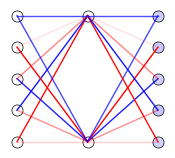

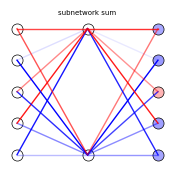

In [22]:
# Load TMS model
input_dim = 5
hidden_dim = 2
n_networks = 1


model_params = dict(eigenmodel.named_parameters())
weights = {k:v for k,v in model_params.items() if 'b' not in k}
weights = {str(i):v.transpose(0,1) for i,v in enumerate(weights.values())}

biases = {k:v for k,v in model_params.items() if 'b' in k}
biases = {str(i+1):v for i,v in enumerate(biases.values())}

f, ax = plt.subplots(figsize=(2, 1.8))
a = DrawNeuralNetwork(weights, biases, ax=ax)
plt.show()


model_params = eigenmodel.reconstruct_network()
weights = {k:v.transpose(0,1) for k,v in model_params.items() if 'b' not in k}
weights = {str(i):v for i,v in enumerate(weights.values())}

biases = {k:v for k,v in model_params.items() if 'b' in k}
biases = {str(i+1):v for i,v in enumerate(biases.values())}

with torch.no_grad():
    f, ax = plt.subplots(figsize=(2, 1.8))
    a = DrawNeuralNetwork(weights, biases, title='subnetwork sum', ax=ax)
    plt.show()

# Figure 3: First 5 Subnetworks

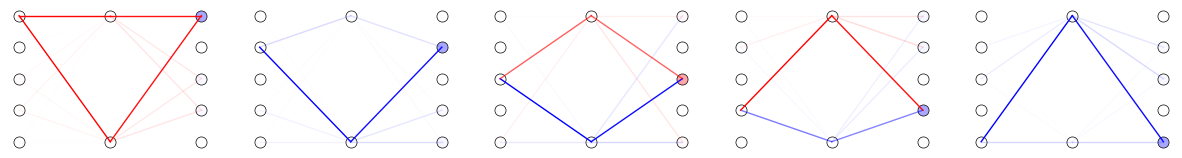

In [23]:
f, axes = plt.subplots(figsize=(15, 1.8), nrows=1, ncols=5)

# Iterate through axes
axes_flat = axes.flatten()
for i, network in enumerate(subnetworks):
    weights = {k:v.transpose(0,1) for k,v in network.items() if 'b' not in k}
    weights = {str(i):v for i,v in enumerate(weights.values())}

    biases = {k:v for k,v in network.items() if 'b' in k}
    biases = {str(i+1):v for i,v in enumerate(biases.values())}

    feature_idx = 5 - abs(biases['1']).argmax().item()

    if feature_idx <= 5:
        DrawNeuralNetwork(weights, biases, ax=axes_flat[feature_idx-1])


f.savefig(figure_names.tms_first_5_subnetworks)
f.savefig(figure_names.tms_first_5_subnetworks.replace('.pdf', '.svg'), transparent=True, bbox_inches='tight')

plt.show()


# Feature Intervention

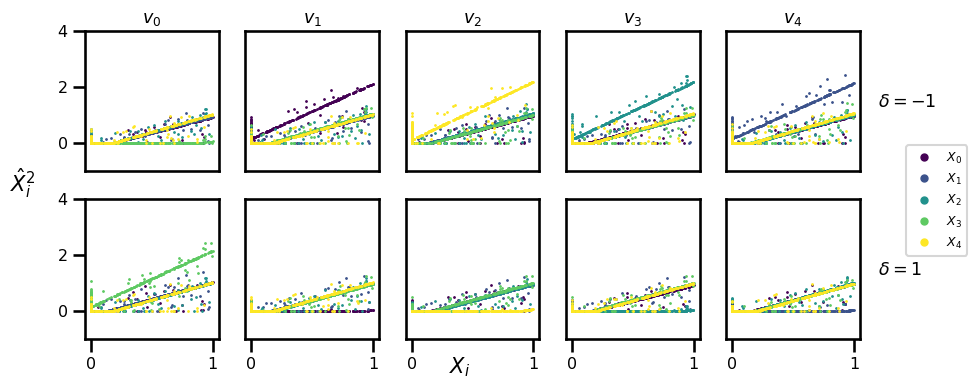

In [24]:
def PerturbAndGraph(delta_values, filename, X, ylim=(-1,2),):
    feature_coefficients = torch.zeros(eigenmodel.n_features).to('cuda')
    toy_model = copy.deepcopy(eigenmodel.model)
    orig_y = toy_model(X)
    f, ax = plt.subplots(len(delta_values),eigenmodel.n_features, figsize=(2*eigenmodel.n_features,2*len(delta_values)))
    for col_i, feature_idx in enumerate(range(eigenmodel.n_features)):
        for row_i, feature_coeff in enumerate(delta_values):
            # Subplot with 2 columns
            feature_coefficients = torch.zeros(eigenmodel.n_features).to('cuda')
            feature_coefficients[feature_idx] = feature_coeff
            reconstruction = eigenmodel.add_to_network(feature_coefficients)
            # Repalce toy model parameters with model_params
            toy_model.load_state_dict(reconstruction)
            y = (toy_model(X) ).cpu().detach().numpy()
            for i in range(y.shape[1]):
                ax[row_i,col_i].plot(X[:,-i].cpu().detach().numpy(), y[:,-i], '.', label=f"${{X}}_{i}$",  markersize=2, c=colors[i]) #, bins=np.linspace(-.1,.1,100), alpha=.5)
                ax[row_i,col_i].set_ylim(ylim)

            ax[0,col_i].set_title(f"$v_{col_i}$")
            ax[0,col_i].set_xticks([])
            # If column is not 0, remove y ticks
            if col_i != 0:
                ax[row_i,col_i].set_yticks([])
                
            if row_i != len(delta_values)-1:
                ax[row_i,col_i].set_xticks([])


    # Set over all figure x and y axes
    f.supylabel('$\hat{X}_{i}^2$', rotation=0, x=.05)
    # Move sup y label closer to the figure

    for i, delta_value in enumerate(delta_values):
        ax[i,-1].text(s=f'$\delta={delta_value}$', y=1.3,x=1.2)


    f.supxlabel('${X}_{i}$', rotation=0)
            
            
    plt.legend(loc='lower left', bbox_to_anchor=(1.3, 0.55), fontsize=9, markerscale=5)

    # Save figure
    plt.savefig(filename, bbox_inches='tight', transparent=True)
    f.savefig(filename.replace('.pdf', '.svg'), bbox_inches='tight', transparent=True)
    plt.show()

X = GenerateTMSInputs(num_features=eigenmodel.n_features, num_datapoints=1000, sparsity=.05)

PerturbAndGraph([-1, 1],figure_names.tms_intervention, X, ylim=(-1,4))



In [25]:
def GetDataframe(delta_values, X):
    df = pd.DataFrame()
    toy_model = copy.deepcopy(eigenmodel.model)
    y0 = toy_model(X).detach().cpu().numpy()
    for circuit_idx in range(eigenmodel.n_features):
        for circuit_coeff in (delta_values):
            # Subplot with 2 columns
            feature_coefficients = torch.zeros(eigenmodel.n_features).to('cuda')
            feature_coefficients[circuit_idx] = circuit_coeff
            
            network = eigenmodel.construct_subnetworks()[circuit_idx]
            circuit_idx_inferred = abs(network['b']).argmax().item()
            reconstruction = eigenmodel.add_to_network(feature_coefficients)
            # Repalce toy model parameters with model_params
            toy_model.load_state_dict(reconstruction)
            y = toy_model(X).cpu().detach().numpy()
            new_df = pd.DataFrame(y-y0)
            new_df[(y0==0) & (y==0)] = pd.NA
            
            new_df['circuit_coeff'] = circuit_coeff
            new_df['subnetwork'] = circuit_idx_inferred
            df = pd.concat([df, new_df])
    return df 


X = GenerateTMSInputs(num_features=eigenmodel.n_features, num_datapoints=1000, sparsity=.05)

df = GetDataframe(np.linspace(-3,3,31), X)
# Melt the DataFrame
df_melted = df.melt(id_vars=['circuit_coeff', 'subnetwork'], var_name="idx", value_name="value")
df_melted = df_melted[~df_melted['value'].isna()]
df_melted = df_melted.groupby(['subnetwork', 'circuit_coeff', 'idx']).median().reset_index()


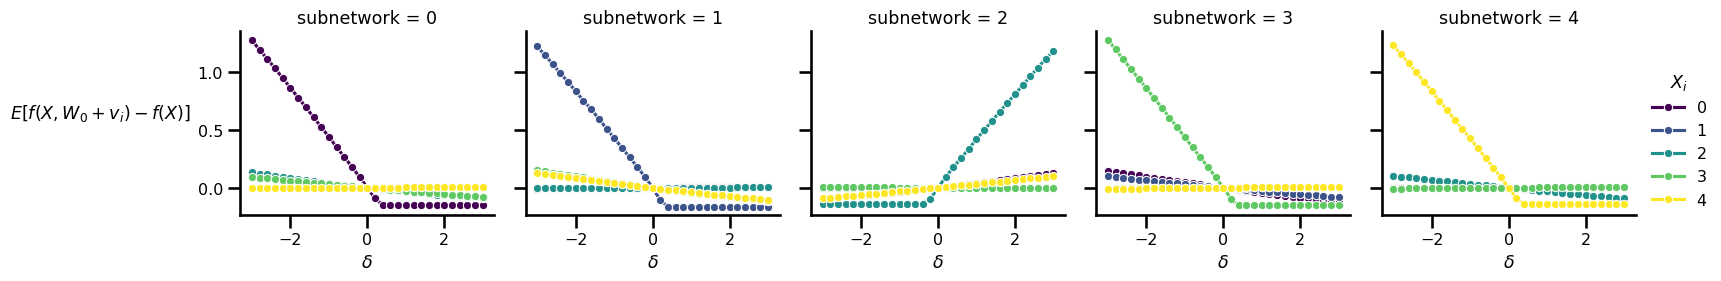

In [26]:
# Set Seaborn color palette to Viridis
sns.set_palette("viridis", 5)
sns.set_context("talk", font_scale=.7)
# Create a FacetGrid for subplots
g = sns.FacetGrid(df_melted, col='subnetwork', sharey=True)  # Adjust col_wrap for layout

# Map violin plot to each subplot, ensuring colors are applied
g.map_dataframe(sns.lineplot, x='circuit_coeff', y='value', hue='idx',  palette="viridis", marker='o', markersize=6)#, inner=None, alpha=0.6, split=False, dodge=False, width=2)
# Adjust subplot aesthetics
g.add_legend(title='$X_i$')
g.set_axis_labels("$\delta$", "$E[{f(X, W_0+v_i) - f(X)}]$", rotation=0)
g.set_ylabels(labelpad=70)
# Set font for all text in plot
# Set x label pad 
# Adjust x ticks
plt.savefig(figure_names.tms_intervention_mean)
